In [1]:
from numpy.lib.npyio import save
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import action_selection as asl
import seaborn as sns
import pandas as pd
from scipy.stats import entropy
plt.style.use('seaborn-whitegrid')
from pandas.plotting import table

0
1
2


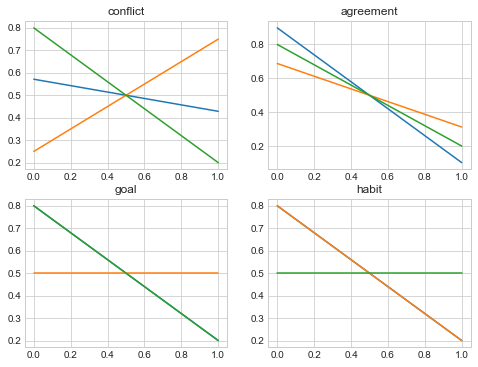

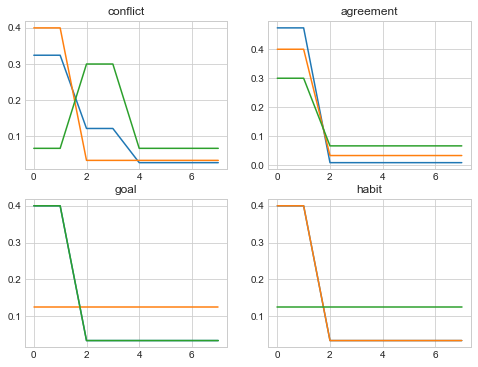

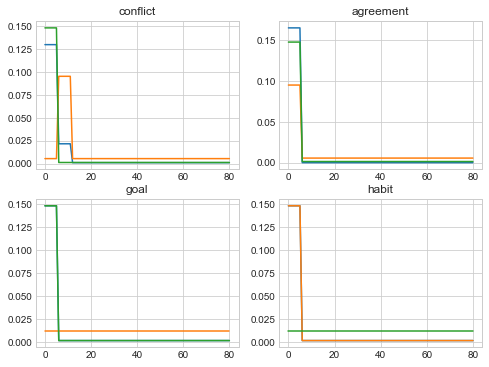

In [2]:
tests = ["conflict", "agreement", "goal", "habit"]#, "uncertainty"]
num_tests = len(tests)
test_vals = [[],[],[]]


#////////// setup 2 policies
npi = 2
flat = [1./npi]*npi

# conflict
l = [0.8,0.2]
conflict_prior = np.ones(2) - l + 0.1
conflict_prior /= conflict_prior.sum()

prior = np.array(conflict_prior)
like = np.array(l)
post = prior*like
post /= post.sum()
test_vals[0].append([post,prior,like])

# agreement
l = np.array([0.8,0.2])
agree_prior = l + 0.3
agree_prior /= agree_prior.sum()

prior = np.array(agree_prior)
like = np.array(l)
post = prior*like
post /= post.sum()
test_vals[0].append([post,prior,like])

# goal
l = [0.8,0.2]
prior = np.array(flat)
like = np.array(l)
post = prior*like
post /= post.sum()
test_vals[0].append([post,prior,like])

# habit
prior = np.array([0.8,0.2])
like = np.array(flat)
post = prior*like
post /= post.sum()
test_vals[0].append([post,prior,like])



# ///////// setup 8 policies

npi = 8
gp = 2
high_prob_1 = 0.4
high_prob_2 = 0.3
flat = np.ones(npi)/npi
h1 = np.array([high_prob_1]*gp + [(1 - high_prob_1*gp)/(npi-gp)]*(npi-gp))
h2_conf = np.array([(1 - high_prob_2*gp)/(npi-gp)]*gp + [high_prob_2]*gp + [(1 - high_prob_2*gp)/(npi-gp)]*(npi-gp*2))
h2_agree = np.array([high_prob_2]*gp + [(1 - high_prob_2*gp)/(npi-gp)]*(npi-gp))

# conflict
prior = h1.copy()
like = h2_conf.copy()
post = prior*like
post /= post.sum()
test_vals[1].append([post,prior,like])

# agreement
prior = h1.copy()
like = h2_agree.copy()
post = prior*like
post /= post.sum()
test_vals[1].append([post,prior,like])

#goal
prior = flat
like = h1.copy()
post = prior*like
post /= post.sum()
test_vals[1].append([post,prior,like])

# habit
prior = h1.copy()
like = flat
post = prior*like
post /= post.sum()
test_vals[1].append([post,prior,like])


#//// setup 81 policies
num_tests = len(tests)
gp = 6
n = 81
val = 0.148
l = [val]*gp+[(1-6*val)/(n-gp)]*(n-gp)
v = 0.00571
p = [(1-(v*(n-gp)))/6]*gp+[v]*(n-gp)
conflict = [v]*gp+[(1-(v*(n-gp)))/6]*gp+[v]*(n-2*gp)
npi = n
flat = [1./npi]*npi

# conflict
prior = np.array(conflict)
like = np.array(l)
post = prior*like
post /= post.sum()
test_vals[2].append([post,prior,like])

# agreement
prior = np.array(p)
like = np.array(l)
post = prior*like
post /= post.sum()
test_vals[2].append([post,prior,like])

# goal
prior = np.array(flat)
like = np.array(l)
post = prior*like
post /= post.sum()
test_vals[2].append([post,prior,like])

# habit
prior = np.array(l)
like = np.array(flat)
post = prior*like
post /= post.sum()
test_vals[2].append([post,prior,like])



for y in range(3):
    print(y)
    fig, ax = plt.subplots(2,2, figsize = (8,6))
    ax = ax.reshape(ax.size)
    for i in range(4):
        ax[i].plot(test_vals[y][i][0], label='posterior')
        ax[i].plot(test_vals[y][i][1], label='prior')
        ax[i].plot(test_vals[y][i][2], label='likelihood')
        ax[i].set_title(tests[i])

    # plt.close()

In [4]:

def create_titles(mode, selector):

    if (selector.type == 'rdm'):
        fig_title = mode + ', ' + 'wd: ' + str(selector.wd) + \
                    ', ' + 's: ' + str(selector.s) + \
                    ', ' + 'b: ' + str(selector.b)
    
        file_title = mode + '_' + 'npi-' + str(npi) + \
                    '_' + 'wd-' + str(selector.wd) + \
                    '_' + 's-' + str(selector.s) + \
                    '_' + 'b-' + str(selector.b) + '.png'
        
    
    elif (selector.type == 'ardm'):
        fig_title = mode + ', ' + 'wd: ' + str(selector.wd) + \
                           ', ' + 'ws: ' + str(selector.ws) + \
                           ', ' + 's: ' + str(selector.s) + \
                           ', ' + 'b: ' + str(selector.b)

        file_title = mode + '_' + 'npi-' + str(npi) + \
                    '_' + 'wd-' + str(selector.wd) + \
                    '_' + 'ws-' + str(selector.ws) + \
                    '_' + 's-' + str(selector.s) + \
                    '_' + 'b-' + str(selector.b) + '.png'
        
    return fig_title,file_title


In [9]:
def run_action_selection(post, prior, like, selector, mode, crit_factor= 0.5, trials = 100, T = 2, plotting=False, s = 0.1):
    
    if (selector == 'ddm'): 
        ac_sel = asl.DDM_RandomWalker(trials,T, s=s)
    elif (selector == 'rdm'):
        ac_sel = asl.RacingDiffusionSelector(trials,T)
    elif (selector == 'ardm'):
        ac_sel = asl.AdvantageRacingDiffusionSelector(trials, T)
    elif (selector == 'dirichlet'):
        ac_sel = asl.DirichletSelector(trials, 2, npi, factor=crit_factor, calc_dkl=False)
    else:
        raise ValueError('selector not given properly')
    
    print(trials)
    actions = []

    for t in range(trials):

        if (selector == 'rdm' or selector == 'ardm'):

            ac_sel.select_desired_action(t, 0, post, list(range(npi)), like, prior, plot=plotting)
            # if (t%10 == 0 and (selector == 'rdm' or selector == 'ardm')):
            #     save_trajectory(mode, ac_sel, selector,t)

        elif(selector == "ddm"):

            actions.append(ac_sel.select_desired_action(t, 0, prior, like, post,True))
        else:

            ac_sel.select_desired_action(t, 0, post, list(range(npi)), like, prior, plot=plotting)
            
    return ac_sel.RT.squeeze(), ac_sel, actions

def save_trajectory(mode,selector,selector_type,t):
    plt.close()
    path = '/home/terraregina/Documents/university/MSc/habit/project/sarah_code/BalancingControl-reaction_times/' + mode + '/'
    plt.plot(selector.trajectory)
    plt.savefig(path + selector_type +'_'+'npi-'+str(npi)+'_'+mode+str(t)+'.png',dpi=100)


1000
1000
1000
1000


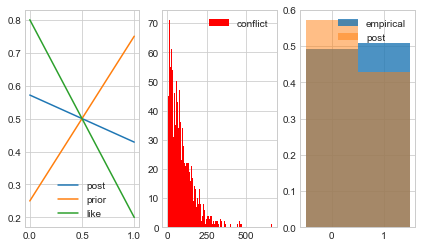

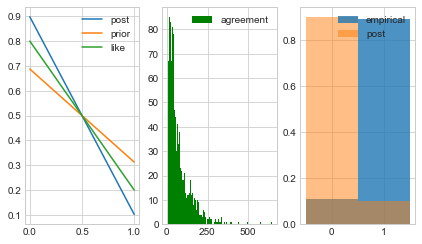

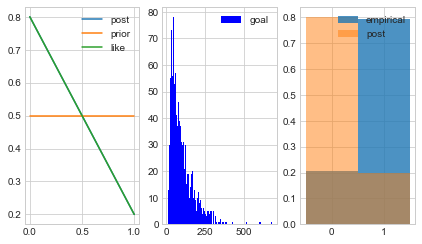

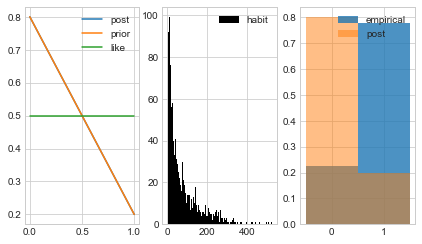

In [8]:
#%% DDM, 2 policies, different variances

vals = np.asarray(test_vals[0])
modes = vals.shape[0]
RTs_overall = []
titles = ['conflict', 'agreement', 'goal', 'habit']
cols = ['r','g','b','k']
trials = 1000
plt.figure()
selector = "ddm"
plt.close()
ss = [0.1,0.05,0.01]
for mode in range(4):

    fig,axs = plt.subplots(1,3, figsize=(7,4))
    #plot rt histogram
    axs[0].plot(post, label="post")
    axs[0].plot(prior, label = "prior")
    axs[0].plot(like, label = "like")
    axs[0].legend()

    RTs = []
    for s in ss:
        # simulate reaction times
        post = vals[mode,0,:]
        prior = vals[mode,1,:]
        like = vals[mode,2,:]
        rt, sampler, actions = run_action_selection(post, prior, like, selector,titles[mode], trials=trials, s=s)

        RTs.append(rt)


        axs[1].hist(rt, bins=100, label=titles[mode], color=cols[mode])
        axs[1].legend()

        # # plot walks
        # for i in range(len(sampler.walks)):
        #     plt.plot(range(0,len(sampler.walks[i])), sampler.walks[i])
        # plt.show()

        # plot actions and how they approximate posterior over actions

        height = np.asarray([trials - np.asarray(actions).sum(), np.asarray(actions).sum()])/trials
        bars = ('0', '1')

        # Choose the width of each bar and their positions
        width = [1,1]
        x_pos = [0,1]
        
        # Make the plot
        axs[2].bar(x_pos, height, width=width, alpha=0.8, label="empirical")
        axs[2].bar(x_pos, post,width=width, alpha=0.5, label="post")
        # axs[2].set_xticks(x_pos, bars)
        axs[2].legend()
        ttl = 'ddm_'+"npi-2_" + titles[mode] + '.png'

    RTs_overall.append(RTs)
    RTs = []
    plt.savefig(ttl)


In [ ]:
#%% Simulation with DDM 2 policies

vals = np.asarray(test_vals[0])
modes = vals.shape[0]
RTs = []
titles = ['conflict', 'agreement', 'goal', 'habit']
cols = ['r','g','b','k']
trials = 1000
plt.figure()
selector = "ddm"
plt.close()

for mode in range(4):
    # simulate reaction times
    post = vals[mode,0,:]
    prior = vals[mode,1,:]
    like = vals[mode,2,:]
    rt, sampler, actions = run_action_selection(post, prior, like, selector,titles[mode], trials=trials)

    RTs.append(rt)

    fig,axs = plt.subplots(1,3, figsize=(7,4))
    
    #plot rt histogram
    axs[0].plot(post, label="post")
    axs[0].plot(prior, label = "prior")
    axs[0].plot(like, label = "like")
    axs[0].legend()

    axs[1].hist(rt, bins=100, label=titles[mode], color=cols[mode])
    axs[1].legend()

    # # plot walks
    # for i in range(len(sampler.walks)):
    #     plt.plot(range(0,len(sampler.walks[i])), sampler.walks[i])
    # plt.show()

    # plot actions and how they approximate posterior over actions

    height = np.asarray([trials - np.asarray(actions).sum(), np.asarray(actions).sum()])/trials
    bars = ('0', '1')

    # Choose the width of each bar and their positions
    width = [1,1]
    x_pos = [0,1]
    
    # Make the plot
    axs[2].bar(x_pos, height, width=width, alpha=0.8, label="empirical")
    axs[2].bar(x_pos, post,width=width, alpha=0.5, label="post")
    # axs[2].set_xticks(x_pos, bars)
    axs[2].legend()
    ttl = 'ddm_'+"npi-2_" + titles[mode] + '.png'
    plt.savefig(ttl)
